# __This notebook will be used to investigate and implement different classification models using the iris data set__

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### __Loading data set__

In [12]:
IRIS_DATASET = pd.read_csv("iris data set\iris.csv")
iris_df = pd.DataFrame(IRIS_DATASET)
print(iris_df.head(5))

   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa


### __Visualizing data__

Unique species:  ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


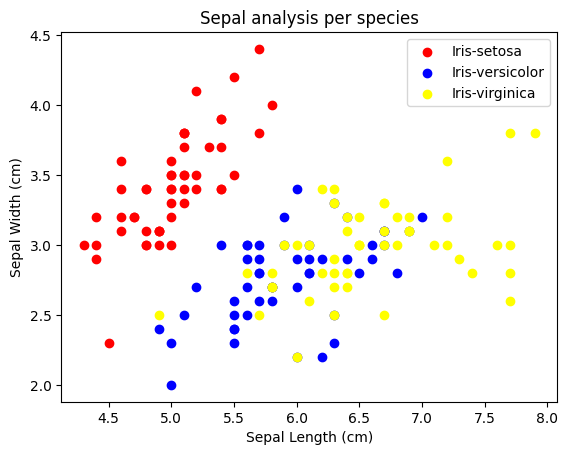

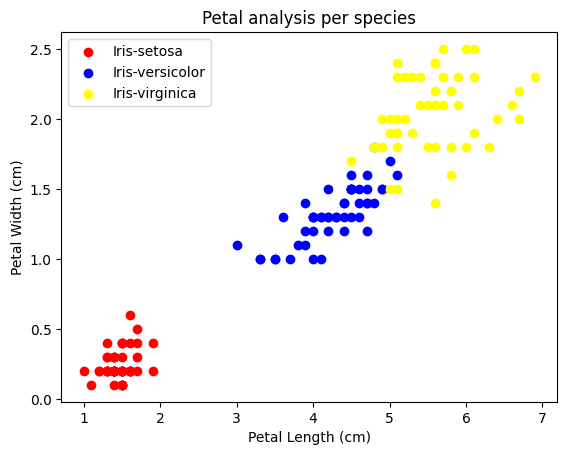

In [26]:

species = iris_df["Species"].unique()
print("Unique species: ", species)

colors = {
    "Iris-setosa": "red",
    "Iris-versicolor": "blue",
    "Iris-virginica":"yellow"
}

setosa_df = iris_df[iris_df["Species"] == "Iris-setosa"]
virginica_df = iris_df[iris_df["Species"] == "Iris-virginica"]
versicolor_df = iris_df[iris_df["Species"] == "Iris-versicolor"]

# print(f"\n setosa \n {setosa_df.head()}")
# print(f"\n virginica \n {virginica_df.head()}" )
# print(f"\n versicolor \n {versicolor_df.head()}")

# sepal area between species 
for sp in species:
    subset = iris_df[iris_df["Species"] == sp]
    # compiles till we plot
    plt.scatter(
        subset["SepalLengthCm"], 
        subset["SepalWidthCm"], 
        color=colors[sp], 
        label=sp
    )

plt.xlabel("Sepal Length (cm)")
plt.ylabel("Sepal Width (cm)")
plt.title("Sepal analysis per species")
plt.legend()
plt.show()

# petal area between species 

for sp in species:
    subset = iris_df[iris_df["Species"] == sp]
    # compiles till we plot
    plt.scatter(
        subset["PetalLengthCm"], 
        subset["PetalWidthCm"], 
        color=colors[sp], 
        label=sp
    )

plt.xlabel("Petal Length (cm)")
plt.ylabel("Petal Width (cm)")
plt.title("Petal analysis per species")
plt.legend()
plt.show()

### __KNN prediction__
#### Vanilla python 